## 1. Import

In [1]:
# 1 라이브러리 임포트

import pandas as pd
import numpy as np
import tensorflow as tf
import sklearn as sk

# 알고리즘을 그래픽화 하기위한 라이브러리
import pandas_profiling 
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import rcParams
import re
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout,Rescaling
import keras

# 모델생성 라이브러리
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda, Concatenate, Add, BatchNormalization, LeakyReLU
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_addons as tfa

# 데이터 스플릿,스케일링
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.preprocessing import MinMaxScaler,StandardScaler

## 2. Load Data

In [2]:
# 1 데이터 불러오기 
path = "./playground-series-s3e6/"
train_csv = pd.read_csv(path+"train.csv")
test_csv = pd.read_csv(path+"test.csv")

## 3. DEA

In [3]:
# train_csv.profile_report()

In [4]:
train_csv.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [5]:
train_csv.dtypes

id                     int64
squareMeters           int64
numberOfRooms          int64
hasYard                int64
hasPool                int64
floors                 int64
cityCode               int64
cityPartRange          int64
numPrevOwners          int64
made                   int64
isNewBuilt             int64
hasStormProtector      int64
basement               int64
attic                  int64
garage                 int64
hasStorageRoom         int64
hasGuestRoom           int64
price                float64
dtype: object

## 4. summarize Data 
NO null  
NO String  
squareMeters have HIGH CORRELATION  

Okay DEA Done now Let's Pretreatment data

In [6]:
print(train_csv.shape)
train_csv.head()

(22730, 18)


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [7]:
# 데이터 스케일링
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
y = train_csv.price
df = train_csv.drop(["price"],axis=1)
df[df.columns] = scaler.fit_transform(df[df.columns])
train_df = df.iloc[:-len(test_csv),:]
train_df['price'] = y[:-len(test_csv)]
test_df = df.iloc[-len(test_csv):,:].reset_index(drop=True)
x = train_df.drop('price', axis=1)
y = train_df.price
test_csv = test_df

/tmp/ipykernel_2002/1190681260.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['price'] = y[:-len(test_csv)]


In [8]:
# 스케일링 이 잘 된지 확인
print(x.shape)
x.head()

(7576, 17)


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom
0,-1.731975,-0.248287,-0.858827,1.049439,-0.909570,-0.006405,-0.477265,-1.308661,-1.703215,-0.067369,-0.937870,1.083453,-1.731413,0.041332,-0.587516,-0.926085,-0.704724
1,-1.731822,0.980586,0.416601,-0.952890,1.099421,0.265698,-0.507925,-1.673695,-0.597415,-0.067369,-0.937870,1.083453,-1.494789,-0.184672,-0.922263,-0.926085,0.277215
2,-1.731670,0.930425,-0.114827,1.049439,1.099421,0.307560,-0.151863,-0.578594,0.876986,0.100947,1.066246,1.083453,0.718523,1.254332,-1.038696,1.079815,1.259155
3,-1.731517,1.021761,1.798316,-0.952890,-0.909570,0.244767,-1.163128,-1.673695,-1.703215,-0.067369,-0.937870,1.083453,0.374252,1.115178,-0.998672,1.079815,1.259155
4,-1.731365,0.306255,1.833744,-0.952890,-0.909570,0.202905,0.474279,0.881541,-0.597415,0.084115,1.066246,-0.922975,0.612846,-0.736770,1.209929,-0.926085,0.604528


In [10]:
# 스케일링 이 잘 된지 확인
print(y.shape)
y.head()

(7576,)


0    3436795.2
1    9519958.0
2    9276448.1
3    9725732.2
4    6181908.8
Name: price, dtype: float64

In [21]:
# 트레인 테스트 스플릿

from sklearn.model_selection import train_test_split


x_train, x_test, y_train,y_test = train_test_split(
    x,
    y,
    train_size=0.8,
    shuffle = True,
    random_state=21
)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

(6060, 17) (1516, 17)
(6060,) (1516,)


In [22]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow_addons as tfa
dr = 0.2

def get_model():
    model = keras.Sequential([
    layers.Dense(512), 
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(256), 
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(128), 
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(64), 
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.BatchNormalization(),
    layers.Dense(32), 
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(16), 
    layers.LeakyReLU(alpha=0.3),
    layers.Dropout(rate=dr),
    layers.Dense(8),
    layers.LeakyReLU(alpha=0.3),
    layers.Dense(1, activation='linear')
   ])

    
    model.compile(
        optimizer = "adam",
        loss="mse",
        # metrics='AUC',
)
    return model

early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        mode='min',
        patience=30,
        min_delta=0.00001,
        restore_best_weights=True,
)
plat = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", 
        mode='min', 
        patience=30, 
        factor=0.1, 
        min_lr=1e-6, 
        min_delta=0.000001)

plat = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, min_lr=1e-6, verbose=1)


In [23]:
model = get_model()

class_weight = 10
history = model.fit(
        x_train, y_train,
        validation_split=0.2,
        batch_size=32,
        epochs=500,
        callbacks=[early_stopping, plat],
        verbose=1
        )


Epoch 1/500
152/152 [==============================] - 2s 5ms/step - loss: 30165887352832.0000 - val_loss: 31074268741632.0000 - lr: 0.0010
Epoch 2/500
152/152 [==============================] - 1s 4ms/step - loss: 30072375345152.0000 - val_loss: 30587683340288.0000 - lr: 0.0010
Epoch 3/500
152/152 [==============================] - 1s 4ms/step - loss: 29112464834560.0000 - val_loss: 28068976525312.0000 - lr: 0.0010
Epoch 4/500
152/152 [==============================] - 1s 4ms/step - loss: 25038644314112.0000 - val_loss: 20637418520576.0000 - lr: 0.0010
Epoch 5/500
152/152 [==============================] - 1s 4ms/step - loss: 16044590628864.0000 - val_loss: 10643811860480.0000 - lr: 0.0010
Epoch 6/500
152/152 [==============================] - 1s 4ms/step - loss: 6534842023936.0000 - val_loss: 2622385029120.0000 - lr: 0.0010
Epoch 7/500
152/152 [==============================] - 1s 4ms/step - loss: 3044469899264.0000 - val_loss: 1630142464000.0000 - lr: 0.0010
Epoch 8/500
152/152 [===

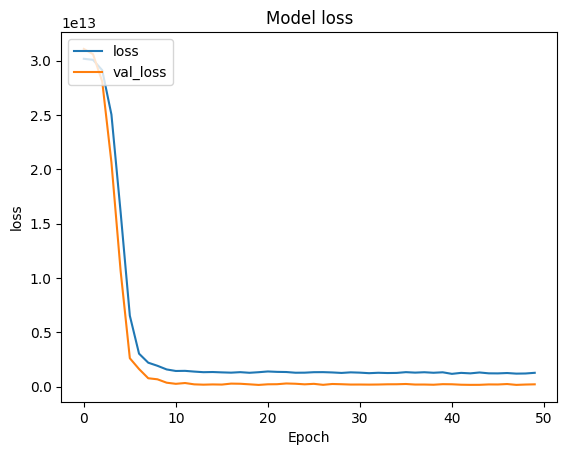

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.show()

In [30]:
preds =[]

# 기존 원핫 인코딩 범위는 0~ 5까지 지만
# 위 데이터의 quailty 범위는 3~8 까지라 3을 더해줌
preds.append(np.argmax(model.predict(test_csv),axis=1))
pred = (np.average(np.array(preds),axis=0))

pred= pred.astype(int)

print(pred[:50])

# 15-3 경로와 파일명 지정
submission = pd.read_csv(path +"sample_submission.csv",index_col="id")
submission['price'] = pred
# 임계값을 0 으로 변경
# submission['quality'] = np.where(submission['quality'] > 0.5, 1 , 0)

submission.to_csv("/kaggle/working/"+"submission_4.csv")

474/474 [==============================] - 1s 1ms/step
[[7179696]
 [6544489]
 [ 412703]
 [6431381]
 [5327036]
 [7899642]
 [8418818]
 [1801786]
 [9463937]
 [9326081]
 [ 547881]
 [4408941]
 [4074159]
 [1633731]
 [8306845]
 [ 720104]
 [1239321]
 [1761186]
 [3963507]
 [ -11837]
 [4428257]
 [5985432]
 [9739629]
 [3630599]
 [6613240]
 [8337546]
 [8057013]
 [8809711]
 [7402511]
 [4122980]
 [7626224]
 [1487189]
 [ 951486]
 [1766919]
 [1745961]
 [7055225]
 [ 706405]
 [1425351]
 [7741270]
 [2923518]
 [5176099]
 [9438392]
 [1815670]
 [2446066]
 [7700260]
 [9824201]
 [6877970]
 [5608029]
 [6798866]
 [8247270]]
